# CartPole-v0

Ref: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

In [2]:
# !sudo cp /opt/conda/lib/libpython3.9.so.1.0 /usr/lib

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.7.0'

In [3]:
import tf_agents
tf_agents.__version__

'0.11.0'

In [93]:
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import sequential, q_network
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils

import matplotlib
import matplotlib.pyplot as plt

import reverb

import tensorflow as tf
import pyvirtualdisplay


import PIL
import numpy as np
import IPython
import imageio
import base64

import os
import time

from absl import logging

In [5]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()


In [98]:
num_iterations = 20000

learning_rate = 1e-4
num_eval_episodes = 10
replay_buffer_max_length = 100000
initial_collect_steps = 100
batch_size = 64
collect_steps_per_iteration = 1

log_interval = 200
eval_interval = 1000

root_dir = './data'
summaries_flush_secs = 10

env_name = 'CartPole-v0'
fc_layer_params = (100, 50)
gamma = 0.99
reward_scale_factor = 1.0
gradient_clipping = None
debug_summaries = False
summarize_grads_and_vars = False

# Params fro train
use_tf_functions = True
train_steps_per_iteration = 1

# Params for collect
epsilon_greedy = 0.1
replay_buffer_capacity = 100_000

# Params for target update
target_update_tau = 0.05
target_update_period = 5

# Params for summaries and logging
summary_interval = 1_000
eval_metrics_callback = None

train_sequence_length = 1

# Params for checkpoints
train_checkpoint_interval = 10_000
policy_checkpoint_interval = 5_000
rb_checkpoint_interval = 20_000

## Setup

In [7]:
root_dir = os.path.expanduser(root_dir)
train_dir = os.path.join(root_dir, 'train')
eval_dir = os.path.join(root_dir, 'eval')

In [8]:
# Train Summary Writer
train_summary_writer = tf.summary.create_file_writer(
    train_dir, flush_millis=summaries_flush_secs * 1000)
train_summary_writer.set_as_default()

In [9]:
# Eval Summary Writer
eval_summary_writer = tf.summary.create_file_writer(
    eval_dir, flush_millis=summaries_flush_secs * 1000)
eval_metrics = [
    tf_metrics.AverageReturnMetric(buffer_size=num_eval_episodes),
    tf_metrics.AverageEpisodeLengthMetric(buffer_size=num_eval_episodes)
]

In [10]:
# Create global_step
global_step = tf.compat.v1.train.get_or_create_global_step()

In [99]:
with tf.summary.record_if(lambda: tf.math.equal(global_step % summary_interval, 0)):
    # Create env
    tf_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
    eval_tf_env = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))
    
    # Create Q network
    q_net = q_network.QNetwork(
        tf_env.observation_spec(),
        tf_env.action_spec(),
        fc_layer_params=fc_layer_params)
    
    # Create Agent
    tf_agent = dqn_agent.DqnAgent(
        time_step_spec=tf_env.time_step_spec(),
        action_spec=tf_env.action_spec(),
        q_network=q_net,
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        
        # Params for collect
        epsilon_greedy=epsilon_greedy,
        
        # Params for target network updates
        target_q_network=None,
        target_update_tau=target_update_tau,  # Default: 1.0, "Factor for soft update of the target network"
        target_update_period=target_update_period,  # Default: 1, "Period for soft update of the target network"
        
        # Params for training
        td_errors_loss_fn=common.element_wise_squared_loss,  # Default: common.element_wise_huber_loss
        gamma=gamma,  # Default: 1.0, Discount for future rewards.
        reward_scale_factor=reward_scale_factor,  # Default: 1.0
        gradient_clipping=gradient_clipping,  # Default: None, "Norm length to clip gradients"
        
        # Params for debugging
        train_step_counter=global_step,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        name=None,  # Default: class name. The agent name.
    )
    tf_agent.initialize()
    
    # Train Metrics
    train_metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.EnvironmentSteps(),
        tf_metrics.AverageReturnMetric(),
        tf_metrics.AverageEpisodeLengthMetric(),
    ]
    
    # Policies
    eval_policy = tf_agent.policy
    collect_policy = tf_agent.collect_policy
    
    # Replay Buffer
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=tf_agent.collect_data_spec,
        batch_size=tf_env.batch_size,
        max_length=replay_buffer_capacity)
    
    # Collect Driver
    collect_driver = dynamic_step_driver.DynamicStepDriver(
        tf_env,
        collect_policy,
        observers=[replay_buffer.add_batch] + train_metrics,
        num_steps=collect_steps_per_iteration)
    
    # Checkpointers
    train_checkpointer = common.Checkpointer(
        ckpt_dir=train_dir,
        agent=tf_agent,
        global_step=global_step,
        metrics=metric_utils.MetricsGroup(train_metrics, 'train_metrics'))
    policy_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(train_dir, 'policy'),
        policy=eval_policy,
        global_step=global_step)
    rb_checkpointer = common.Checkpointer(
        ckpt_dir=os.path.join(train_dir, 'replay_buffer'),
        max_to_keep=1,
        replay_buffer=replay_buffer)
    
    train_checkpointer.initialize_or_restore()
    rb_checkpointer.initialize_or_restore()
    
    # Speed up with common.function
    if use_tf_functions:
        collect_driver.run = common.function(collect_driver.run)
        tf_agent.train = common.function(tf_agent.train)
        
    # Collect initial replay buffer data.
    
    initial_collect_policy = random_tf_policy.RandomTFPolicy(
        tf_env.time_step_spec(),
        tf_env.action_spec(),
    )
    
    logging.info(
        'Initializing replay buffer by collecting experience for %d steps with '
        'a random policy.', initial_collect_steps)
    
    dynamic_step_driver.DynamicStepDriver(
        tf_env,
        initial_collect_policy,
        observers=[replay_buffer.add_batch] + train_metrics,
        num_steps=initial_collect_steps).run()
    
    results = metric_utils.eager_compute(
        eval_metrics,
        eval_tf_env,
        eval_policy,
        num_episodes=num_eval_episodes,
        train_step=global_step,
        summary_writer=eval_summary_writer,
        summary_prefix='Metrics',
    )
    if eval_metrics_callback is not None:
        eval_metrics_callback(results, global_step.numpy())
    metric_utils.log_metrics(eval_metrics)
    
    time_step = None
    policy_state = collect_policy.get_initial_state(tf_env.batch_size)
    
    # Variables for logging time (steps_per_sec)
    timed_at_step = global_step.numpy()
    time_acc = 0  # Time accumulation
    
    # Dataset
    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=train_sequence_length + 1,
        single_deterministic_pass=False,
    ).prefetch(3)
    iterator = iter(dataset)
    
    def train_step():
        experience, _ = next(iterator)
        return tf_agent.train(experience)
    
    if use_tf_functions:
        train_step = common.function(train_step)
        
    for _ in range(num_iterations):
        start_time = time.time()
        time_step, policy_state = collect_driver.run(
            time_step=time_step,
            policy_state=policy_state,
        )
        
        for _ in range(train_steps_per_iteration):
            train_loss = train_step()
        time_acc += time.time() - start_time
        
        if global_step.numpy() % log_interval == 0:
            logging.info('step = %d, loss = %f', global_step.numpy(),
                         train_loss.loss)
            steps_per_sec = (global_step.numpy() - timed_at_step) / time_acc
            logging.info('%.3f steps/sec', steps_per_sec)
            tf.compat.v2.summary.scalar(
                name='global_steps_per_sec', data=steps_per_sec, step=global_step)
            
            # Reset time.
            timed_at_step = global_step.numpy()
            time_acc = 0
        
        for train_metric in train_metrics:
            train_metric.tf_summaries(
                train_step=global_step, step_metrics=train_metrics[:2])
            
        if global_step.numpy() % train_checkpoint_interval == 0:
            train_checkpointer.save(global_step=global_step.numpy())
        if global_step.numpy() % policy_checkpoint_interval == 0:
            policy_checkpointer.save(global_step=global_step.numpy())
        if global_step.numpy() % rb_checkpoint_interval == 0:
            rb_checkpointer.save(global_step=global_step.numpy())
            
        if global_step.numpy() % eval_interval == 0:
            results = metric_utils.eager_compute(
                eval_metrics,
                eval_tf_env,
                eval_policy,
                num_episodes=num_eval_episodes,
                train_step=global_step,
                summary_writer=eval_summary_writer,
                summary_prefix='Metrics',
            )
            if eval_metrics_callback is not None:
                eval_metrics_callback(results, global_step.numpy())
            metric_utils.log_metrics(eval_metrics)

## Environment

In [12]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

In [13]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.04540078, -0.03908536, -0.04626149, -0.03462004], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [14]:
frame = env.render(mode='rgb_array')

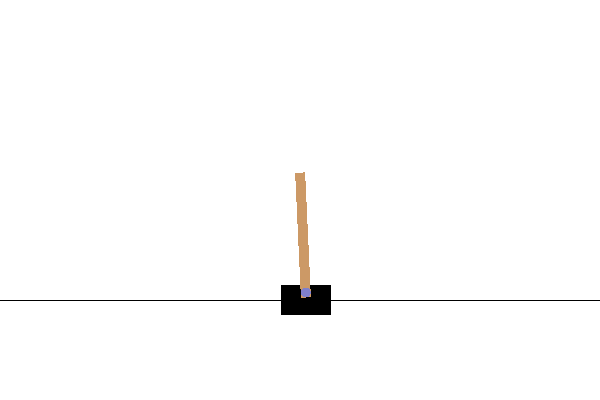

In [15]:
PIL.Image.fromarray(frame)

In [16]:
print('Time Step Spec:')
print(env.time_step_spec())

Time Step Spec:
TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})


In [17]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [18]:
time_step = env.reset()
time_step


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.01729036, -0.02413676, -0.04724762,  0.02772108], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [19]:
action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
next_time_step

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.0177731,  0.1716298, -0.0466932, -0.2794867], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})

In [20]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

In [21]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

In [22]:
def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))

In [23]:
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

In [24]:
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

In [25]:
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [27]:
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policy

In [28]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

### Random Policy Example

In [29]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [30]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [31]:
time_step = example_environment.reset()

In [32]:
# for _ in range(100):
#     action = random_policy.action(time_step)
    
#     time_step = example_environment.step(action)
    
#     print(time_step.is_last(), time_step.reward, action)

## Metrics and Evaluation

In [33]:
def compute_avg_return(environment, policy, num_episodes=10):
    
    total_return = 0.0
    for _ in range(num_episodes):
        
        time_step = environment.reset()
        episode_return =0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            
        total_return += episode_return
        
    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [34]:
compute_avg_return(example_environment, random_policy, num_eval_episodes)

22.1

## Replay Buffer

In [35]:
table_name = 'uniform_table'

replay_buffer_signature = tensor_spec.from_spec(
    agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2) # Current and next observation.

In [36]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [37]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

In [38]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([-0.08405016, -1.0159218 ,  0.06410889,  1.4163557 ], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [39]:
# iter(replay_buffer.as_dataset()).next()

In [40]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 4),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), SampleInfo(key=(64, 2), probability=(64, 2), table_size=(64, 2), priority=(64, 2))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), SampleInfo(key=tf.uint64, probability=tf.float64, table_size=tf.int64, priority=tf.float64))>

In [41]:
iterator = iter(dataset)
print(iterator)

In [42]:
# iterator.next()

## Training the Agent

In [43]:
try:
    %%time
except:
    pass

In [44]:
agent.train = common.function(agent.train)

In [45]:
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

In [46]:
returns

[9.3]

In [47]:
time_step = train_py_env.reset()

In [48]:
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

In [49]:
for _ in range(num_iterations):
    time_step, _ = collect_driver.run(time_step)
    
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    
    step = agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print(f'step = {step}: loss = {train_loss}')
        
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print(f'step = {step}: Average Return = {avg_return}')
        returns.append(avg_return)
        

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


TypeError: Input 'step' of 'WriteSummary' Op has type int32 that does not match expected type of int64.

In [ ]:
iterations = range(0, len(returns) * eval_interval, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [ ]:
plt.show()

## Video

In [ ]:
def embed_mp4(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + '.mp4'
    print('#1')
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            print('#2')
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render(mode='rgb_array'))
            while not time_step.is_last():
                print('#3')
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render(mode='rgb_array'))
                
    # return embed_mp4(filename)

In [ ]:
# create_policy_eval_video(agent.policy, 'trained-agent',num_episodes=1)
# create_policy_eval_video(random_policy, 'trained-agent',num_episodes=1)

In [ ]:
policy = agent.policy
filename = 'trained-agent' + policy.name
fps = 30
num_episodes = 5

In [ ]:
random_policy.name

In [ ]:
filename = filename + '.mp4'
print('#1')
with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
        print('#2')
        time_step = eval_env.reset()
        video.append_data(eval_py_env.render(mode='rgb_array'))
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render(mode='rgb_array'))

In [ ]:
embed_mp4(filename)